In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Load data (AAPL stock closing prices)
# ticker = 'AAPL'
# data = yf.download(ticker, start='2010-01-01', end='2025-01-01', progress=False)
data = pd.read_excel("/kaggle/input/1dcnn-yahoofinance/yahoo_data.xlsx")
series = data['Adj Close**'].values.reshape(-1, 1)  # Use 'Close' for prediction


# Step 2: Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series)





In [3]:
# Create sequences (lookback=60 days)
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 60
X, y = create_sequences(series_scaled, lookback)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for 1D CNN

# Train-test split (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [12]:
# Step 3: Build 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(lookback, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))  # Output layer for regression


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 4: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)



Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0190 - val_loss: 7.4747e-04
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0097 - val_loss: 0.0014
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0088 - val_loss: 0.0013
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0097 - val_loss: 7.0973e-04
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 7.7252e-04
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090 - val_loss: 0.0024
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081 - val_loss: 0.0013
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0089 - val_loss: 8.3190e-04
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0079 - val_loss: 7.6369e-04
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0086 - val_loss: 0.0011
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0082 - val_loss: 5.8364e-04
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


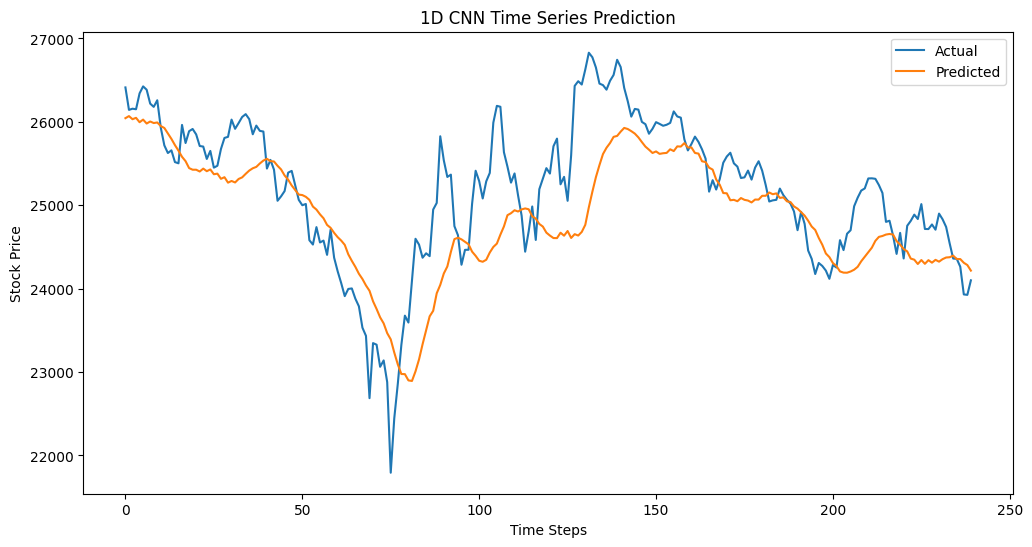

In [5]:
# Step 5: Predict and evaluate
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))



# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('1D CNN Time Series Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
print(f'RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

In [9]:
# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = math.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

In [10]:
# Print results
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MSE: 394476.99
MAE: 476.63
RMSE: 628.07
MAPE: 1.89%
